In [65]:
# Instalar las librerias
#!pip install pandas
#!pip install scikit-learn
# D:\01_MaestriaAnalitica_UnivAndes\07_ML_NLP\S4\Proyecto\pry_pric_cars\venv\Scripts\pip.exe install -r requirements.txt
#!pip install imblearn
#!pip install xgboost==1.6.1   
#pip install scikit_learn==1.1.1  
!pip install -U scikit-learn==1.1.1
#!pip freeze

In [1]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import os

### Analisis Exploratorio de Datos

In [2]:
directorio = os.path.split(os.getcwd())[0]
test_df = pd.read_csv(os.path.join("../INPUT/","dataTest_carListings.csv"))
train_df = pd.read_csv(os.path.join("../INPUT/","dataTrain_carListings.csv"))

In [3]:
train_df.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [6]:
train_df['Mileage'].describe()

count    4.000000e+05
mean     5.507296e+04
std      4.088102e+04
min      5.000000e+00
25%      2.584100e+04
50%      4.295500e+04
75%      7.743300e+04
max      2.457832e+06
Name: Mileage, dtype: float64

Se cuenta con un Data Frame que contiene información de los precios de diferentes vehiculos junto con información del año de fabricación, Millas, Estado, Marca y Modelo. 

Con base en esta información se procede a realizar un analisis de cada variable

#### Price

Conteo de outliers:  10880


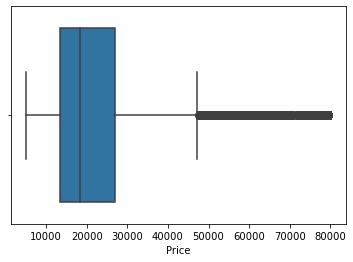

In [45]:
## Se procede a verificar si existen outliers de la variable precio

# Crear el boxplot
sns.boxplot(x=train_df["Price"])

# Calcular el conteo de outliers
q1, q3 = train_df["Price"].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = train_df[(train_df["Price"] < lower_bound) | (train_df["Price"] > upper_bound)]["Price"].count()

# Imprimir el conteo de outliers
print("Conteo de outliers: ", outliers)


# Mostrar el boxplot
plt.show()

Como se puede observar se cuenta con un número de 10.880 outliers comparado con el total de datos que se dispone de 400.000 es equivalente al 2,72% del total de datos. 

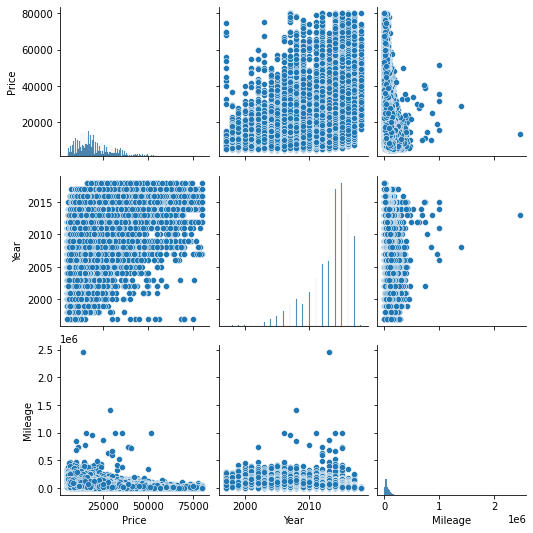

In [46]:
## Se procede a realizar un pairplot entre Price y las variables Númericas
sns.pairplot(train_df[["Price", "Year", "Mileage"]])

Se puede observar que existe una leve relación entre los precios y los Años y Millas. Mientras más reciente sea el año mayor el Precio y mientras más Millas menor el Precio. Esto puede estar demarcando una correlación importante. 

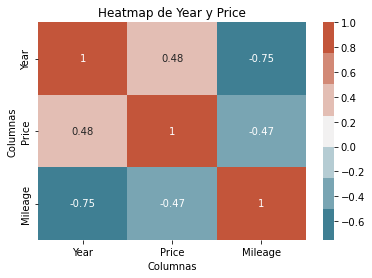

In [47]:
# Se realiza un comparación de la correlación con el resto de variables númericas

my_palette = sns.diverging_palette(220, 20, n=7)

sns.heatmap(train_df[["Year", "Price", "Mileage"]].corr(), annot=True, cmap=my_palette)

plt.title("Heatmap de Year y Price")
plt.xlabel("Columnas")
plt.ylabel("Columnas")

# Mostrar la gráfica
plt.show()

##### Year

In [48]:
# Se verifican los valores que han tomado los años para ver si existe un valor fuera de lo comun
year_counts = train_df["Year"].value_counts().to_frame()

# Renombrar las columnas
year_counts.columns = ["Conteo"]

# Mostrar el DataFrame resultante
print(year_counts)

      Conteo
2015   71441
2014   68181
2016   55947
2017   44790
2013   32307
2012   30907
2011   23828
2010   16650
2008   13509
2007   11003
2009   10676
2006    7185
2005    4881
2004    3423
2003    1927
2002    1188
2001     747
2000     474
2018     371
1999     298
1998     169
1997      98


Con este rápido conteo se puede verificar que no existen valores que no tienen sentido (años futuros o años que no son lógicos, por ejemplo 3005 o 1120)

c:\Users\Felipe\anaconda3\envs\Financiero\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


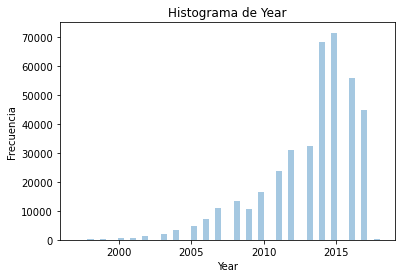

In [49]:
# Se realiza una gráfica rápida para verificar la distribución
# Crear el histograma
sns.distplot(train_df["Year"], kde=False)

# Añadir etiquetas
plt.title("Histograma de Year")
plt.xlabel("Year")
plt.ylabel("Frecuencia")

# Mostrar la gráfica
plt.show()

Viendo la gráfica se puede observar que existe una concentración en vehiculos con Años superiores al 2010.

#### Mileage

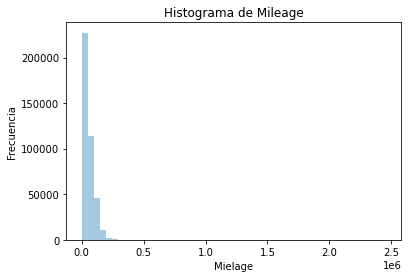

In [50]:
# Se realiza una gráfica rápida para verificar la distribución
# Crear el histograma
sns.distplot(train_df["Mileage"], kde=False)

# Añadir etiquetas
plt.title("Histograma de Mileage")
plt.xlabel("Mielage")
plt.ylabel("Frecuencia")

# Mostrar la gráfica
plt.show()

Conteo de outliers:  9792


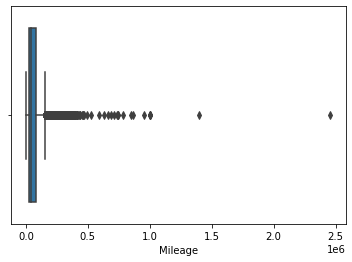

In [51]:
## Se procede a verificar si existen outliers de la variable Mileage

# Crear el boxplot
sns.boxplot(x=train_df["Mileage"])

# Calcular el conteo de outliers
q1, q3 = train_df["Mileage"].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = train_df[(train_df["Mileage"] < lower_bound) | (train_df["Mileage"] > upper_bound)]["Mileage"].count()

# Imprimir el conteo de outliers
print("Conteo de outliers: ", outliers)


#### State

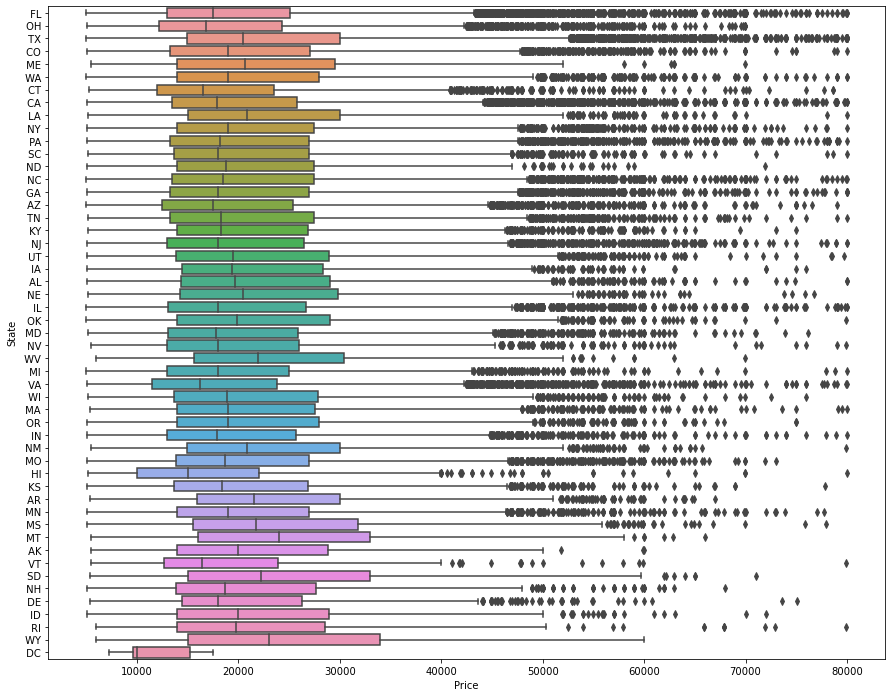

In [52]:
## Se verifica como esta distribudio los diferentes State del vehiculo respecto al Precio
plt.figure(figsize=(15, 12))
sns.boxplot(data=train_df, x=train_df['Price'], y=train_df['State'])
plt.show()

#### Make

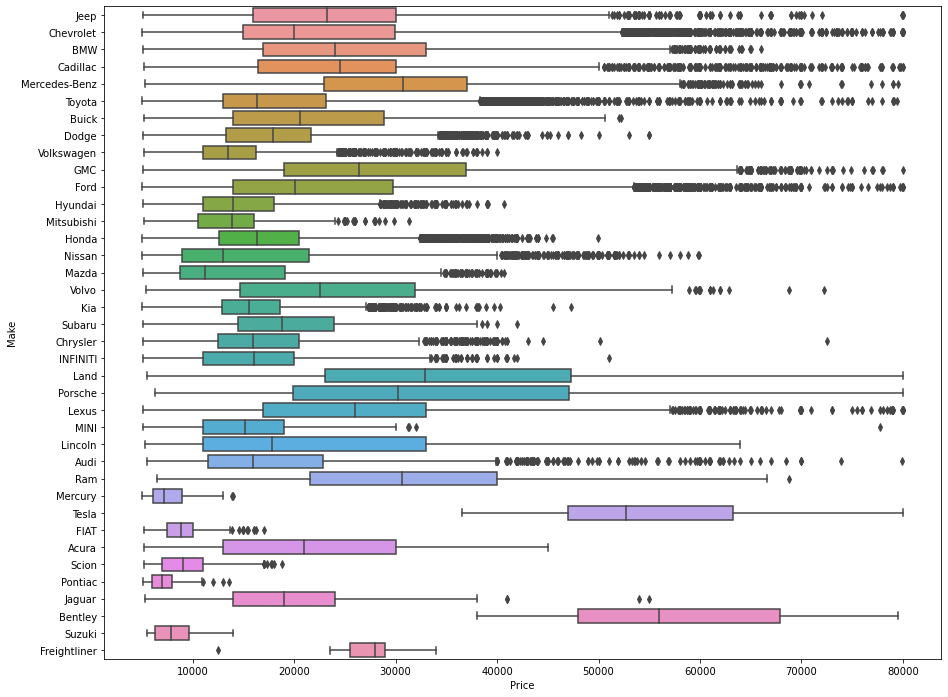

In [53]:
## Se verifica como esta distribudio los diferentes Make del vehiculo respecto al Precio
plt.figure(figsize=(15, 12))
sns.boxplot(data=train_df, x=train_df['Price'], y=train_df['Make'])
plt.show()

#### Model

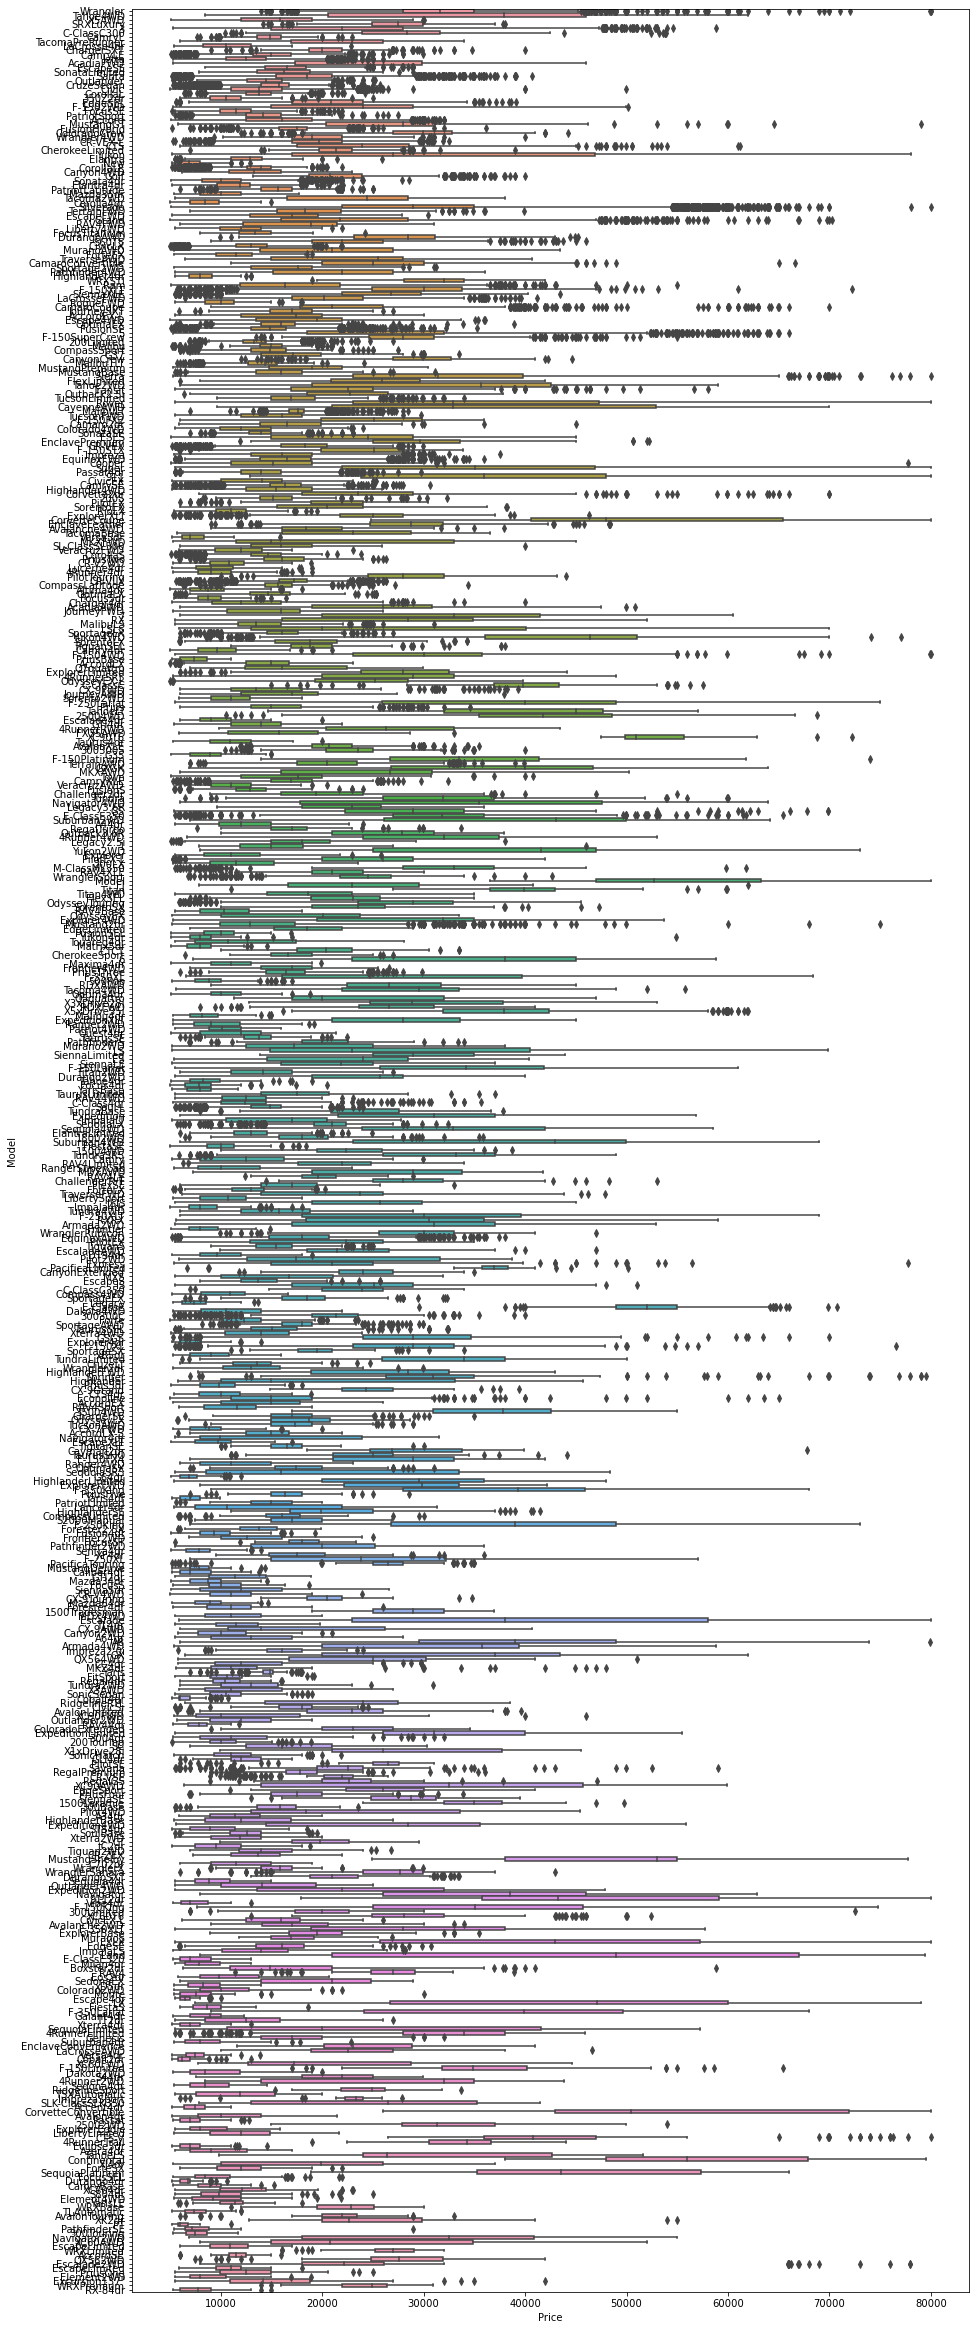

In [54]:
## Se verifica como esta distribudio los diferentes Modelos del vehiculo respecto al Precio
plt.figure(figsize=(15, 42))
sns.boxplot(data=train_df, x=train_df['Price'], y=train_df['Model'])
plt.show()

### Preprocesamiento de Datos

In [13]:
train_df[['Model','Make']].head(10)

,Model,Make
0,Wrangler,Jeep
1,Tahoe4WD,Chevrolet
2,X5AWD,BMW
3,SRXLuxury,Cadillac
4,Wrangler,Jeep
5,3,BMW
6,C-ClassC300,Mercedes-Benz
7,CamryL,Toyota
8,TacomaPreRunner,Toyota
9,LaCrosse4dr,Buick


In [7]:
## Se realiza la verificación de que no haya datos faltantes

missing_values_train = train_df.isnull().sum()

results_train = pd.DataFrame({'Column': missing_values_train.index, 'Missing Values': missing_values_train.values})

print(results_train)

    Column  Missing Values
0    Price               0
1     Year               0
2  Mileage               0
3    State               0
4     Make               0
5    Model               0


In [55]:
### cambios
directorio = os.path.split(os.getcwd())[0]
test_df = pd.read_csv(os.path.join("../INPUT/","dataTest_carListings.csv"))
train_df = pd.read_csv(os.path.join("../INPUT/","dataTrain_carListings.csv"))

## Se realiza la verificación de que no haya datos faltantes

missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

results_train = pd.DataFrame({'Column': missing_values_train.index, 'Missing Values': missing_values_train.values})
results_test = pd.DataFrame({'Column': missing_values_test.index, 'Missing Values': missing_values_test.values})

print(results_train)
print(results_test)

    Column  Missing Values
0    Price               0
1     Year               0
2  Mileage               0
3    State               0
4     Make               0
5    Model               0
    Column  Missing Values
0       ID               0
1     Year               0
2  Mileage               0
3    State               0
4     Make               0
5    Model               0


### Modelado

In [58]:
# define the features and target variable
X = train_df.drop(['Price'], axis=1)
y = train_df['Price']

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
directorio = os.path.split(os.getcwd())[0]
test_df = pd.read_csv(os.path.join("../INPUT/","dataTest_carListings.csv"))
train_df = pd.read_csv(os.path.join("../INPUT/","dataTrain_carListings.csv"))

X_train = train_df.iloc[:,1:]
X_test = test_df.iloc[:,1:]
y_train = train_df.iloc[:,0]
y_test = test_df.iloc[:,0]

X_train

,Year,Mileage,State,Make,Model
0,2017,9913,FL,Jeep,Wrangler
1,2015,20578,OH,Chevrolet,Tahoe4WD
2,2012,83716,TX,BMW,X5AWD
3,2014,28729,OH,Cadillac,SRXLuxury
4,2013,64032,CO,Jeep,Wrangler
...,...,...,...,...,...
399995,2015,25287,TX,Lexus,RXRX
399996,2015,17677,MI,Chevrolet,EquinoxFWD
399997,2014,66688,NC,Buick,EnclaveLeather
399998,2014,37872,IN,Volkswagen,Jetta


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time

# Train the model without parallelization
params = {'objective': 'multi:softmax', 'num_class': 7, 'n_jobs': 1}

print("Training model without parallelization.")
start_time = time.time()
model = xgb.train(params, xgb.DMatrix(X_train, label=y_train))
elapsed_time_no_parallel = time.time() - start_time

# Train the model with parallelization
params_parallel = {'objective': 'multi:softmax', 'num_class': 7, 'n_jobs': -1}

print("Training model with parallelization.")
start_time_parallel = time.time()
model_parallel = xgb.train(params_parallel, xgb.DMatrix(X_train, label=y_train))
elapsed_time_parallel = time.time() - start_time_parallel

# Print the time comparisons
print(f"Training time without parallelization: {elapsed_time_no_parallel:.2f} seconds")
print(f"Training time with parallelization: {elapsed_time_parallel:.2f} seconds")


Training model with parallelization.


AttributeError: module 'xgboost' has no attribute 'train'